In [8]:
import torch
import torchvision
from torchvision import transforms
import pytorch_lightning as pl
import numpy as np
import matplotlib.pyplot as plt
import pydicom
import cv2

In [9]:
class PneumoniaModel(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.model = torchvision.models.resnet18()
        self.model.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        self.model.fc = torch.nn.Linear(in_features=512, out_features=1)
        self.feature_map = torch.nn.Sequential(*list(self.model.children())[:-2])

    def forward(self, data):
        feature_map = self.feature_map(data)
        avg_pool_output = torch.nn.functional.adaptive_avg_pool2d(input=feature_map, output_size=(1, 1))
        avg_output_flattened = torch.flatten(avg_pool_output, 1)
        pred = self.model.fc(avg_output_flattened)
        return pred, feature_map

In [10]:
def cam(model, img):
    with torch.no_grad():
        pred, features = model(img.unsqueeze(0))
    features = features.reshape((512, 7, 7))
    weight_params = list(model.model.fc.parameters())[0]
    weight = weight_params.detach()
    cam = torch.matmul(weight, features.reshape((512, 49))).reshape(7, 7).cpu()
    return cam, torch.sigmoid(pred)

In [11]:
def visualize_prediction(img, cam, pred):
    img = img[0]
    cam = transforms.functional.resize(cam.unsqueeze(0).unsqueeze(0), (224, 224), antialias=True)[0][0]
    fig, axis = plt.subplots(1, 2)
    axis[0].imshow(img.cpu().numpy(), cmap='gray')
    axis[1].imshow(img.cpu().numpy(), cmap='gray')
    axis[1].imshow(cam, alpha=0.5, cmap='jet')
    plt.title(pred > 0.5)
    plt.show()

In [12]:
dcm_path = "00b4e593-fcf8-488c-ae55-751034e26f16.dcm"
dcm = pydicom.read_file(dcm_path).pixel_array / 255.0
dcm_array = cv2.resize(dcm, (224, 224)).astype(np.float32)
val_transforms = transforms.Compose([transforms.ToTensor(), transforms.Normalize(0.49, 0.248)])
img_tensor = val_transforms(dcm_array).unsqueeze(0).to('cuda')

In [13]:
model = PneumoniaModel.load_from_checkpoint('Trained-Model.ckpt', strict=False)
model.eval();

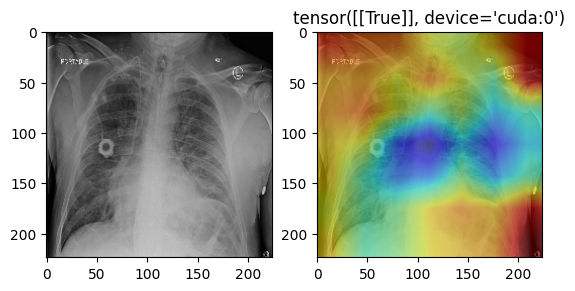

tensor([[True]], device='cuda:0')


In [14]:
activation_map, pred = cam(model, img_tensor.squeeze(0))
visualize_prediction(img_tensor.squeeze(0), activation_map, pred)